In [32]:
import sys

sys.path.append("../")

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

In [35]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [36]:
%config InlineBackend.figure_format = 'retina'

In [37]:
EXPERIMENT_NAME = "benchmarks"
# EXPERIMENT_NAME = "test_benchmarks_temp"
# DOMAIN = "re2"
DOMAIN = "clevr"
COMPUTE_LIKELIHOODS = False

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
FIGURES_DOMAIN_DIR = os.path.join("figures", EXPERIMENT_NAME, DOMAIN)
os.makedirs(FIGURES_DOMAIN_DIR, exist_ok=True)

In [38]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
)

Experiment directory: ../experiments_iterative/outputs/benchmarks
Available domains: ['re2', 'clevr']


# Desired analyses
- num tasks solved in train/test per laps iteration
- num task solved vs. search time

### Tasks solved vs. LAPS iteration

In [39]:
df = analyzer.get_synthesis_results_for_domain(DOMAIN)
df

,request,task,programs,best_search_time,split,seed,iteration,experiment_type
0,"{'constructor': '->', 'arguments': [{'construc...",0-1_compare_integer-Is the number of large rub...,[{'program': '(lambda (clevr_eq_color (clevr_q...,1.302114,train,0,0,enumeration
1,"{'constructor': '->', 'arguments': [{'construc...",1-1_compare_integer-Is the number of metal sph...,[{'program': '(lambda (clevr_gt? 1 (clevr_coun...,19.498133,train,0,0,enumeration
2,"{'constructor': '->', 'arguments': [{'construc...",2-1_compare_integer-Is the number of cyan rubb...,[{'program': '(lambda (clevr_eq_size (clevr_if...,9.547661,train,0,0,enumeration
3,"{'constructor': '->', 'arguments': [{'construc...",3-1_compare_integer-Is the number of large cyl...,[{'program': '(lambda (clevr_eq_size (clevr_if...,39.331395,train,0,0,enumeration
4,"{'constructor': '->', 'arguments': [{'construc...",4-1_compare_integer-Is the number of small yel...,[],NaN,train,0,0,enumeration
...,...,...,...,...,...,...,...,...
2053,"{'constructor': '->', 'arguments': [{'construc...",5-2_transform-If all of the cyan cylinders bec...,[],NaN,test,0,2,enumeration_stitch
2054,"{'constructor': '->', 'arguments': [{'construc...",6-2_transform-If all of the gray cubes became ...,[],NaN,test,0,2,enumeration_stitch
2055,"{'constructor': '->', 'arguments': [{'construc...",7-2_transform-If all of the large purple thing...,[],NaN,test,0,2,enumeration_stitch
2056,"{'constructor': '->', 'arguments': [{'construc...",8-2_transform-If all of the small rubber spher...,[],NaN,test,0,2,enumeration_stitch


In [40]:
df_results = (
    df.groupby(["experiment_type", "seed", "iteration", "split"])
    .best_search_time.count()
    .reset_index(name="n_solved")
)

# Duplicate "benchmark_enumeration" for n_iterations
df_list = [df_results[df_results.experiment_type != "enumeration"]]
for iteration in sorted(df_results.iteration.unique()):
    df_tmp = df_results[df_results.experiment_type == "enumeration"].copy()
    df_tmp["iteration"] = iteration
    df_list.append(df_tmp)
df_results = pd.concat(df_list, axis=0).reset_index(drop=True)

df_results

,experiment_type,seed,iteration,split,n_solved
0,enumeration_codex_stitch,0,0,test,29
1,enumeration_codex_stitch,0,0,train,37
2,enumeration_codex_stitch,0,1,test,30
3,enumeration_codex_stitch,0,1,train,38
4,enumeration_codex_stitch,0,2,test,30
5,enumeration_codex_stitch,0,2,train,41
6,enumeration_stitch,0,0,test,28
7,enumeration_stitch,0,0,train,37
8,enumeration_stitch,0,1,test,26
9,enumeration_stitch,0,1,train,42


<AxesSubplot:xlabel='iteration', ylabel='n_solved'>

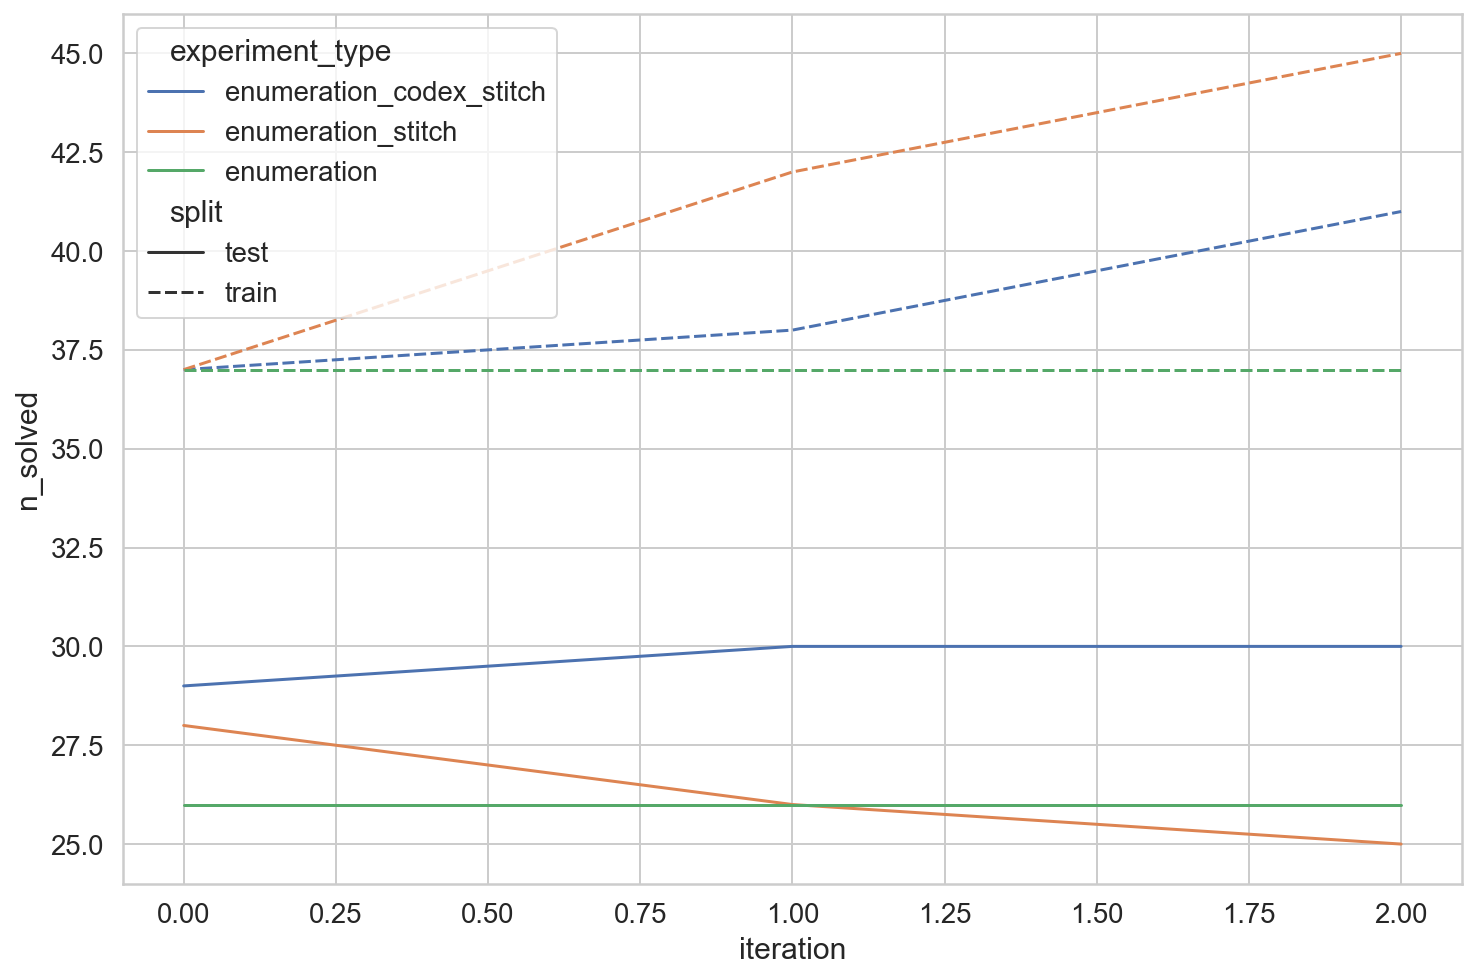

In [41]:
sns.lineplot(
    data=df_results, x="iteration", y="n_solved", hue="experiment_type", style="split"
)

### Tasks solved vs. search time

In [29]:
df_search_time = analyzer.get_search_time_results_for_domain(DOMAIN)
df_search_time

Using enumeration_timeout: 120


,time,n_solved,experiment_type,seed,iteration,split
0,0,0,enumeration,0,0,test
1,1,4,enumeration,0,0,test
2,2,13,enumeration,0,0,test
3,3,16,enumeration,0,0,test
4,4,16,enumeration,0,0,test
...,...,...,...,...,...,...
963,116,45,enumeration_stitch,0,2,train
964,117,45,enumeration_stitch,0,2,train
965,118,45,enumeration_stitch,0,2,train
966,119,45,enumeration_stitch,0,2,train


<AxesSubplot:xlabel='time', ylabel='n_solved'>

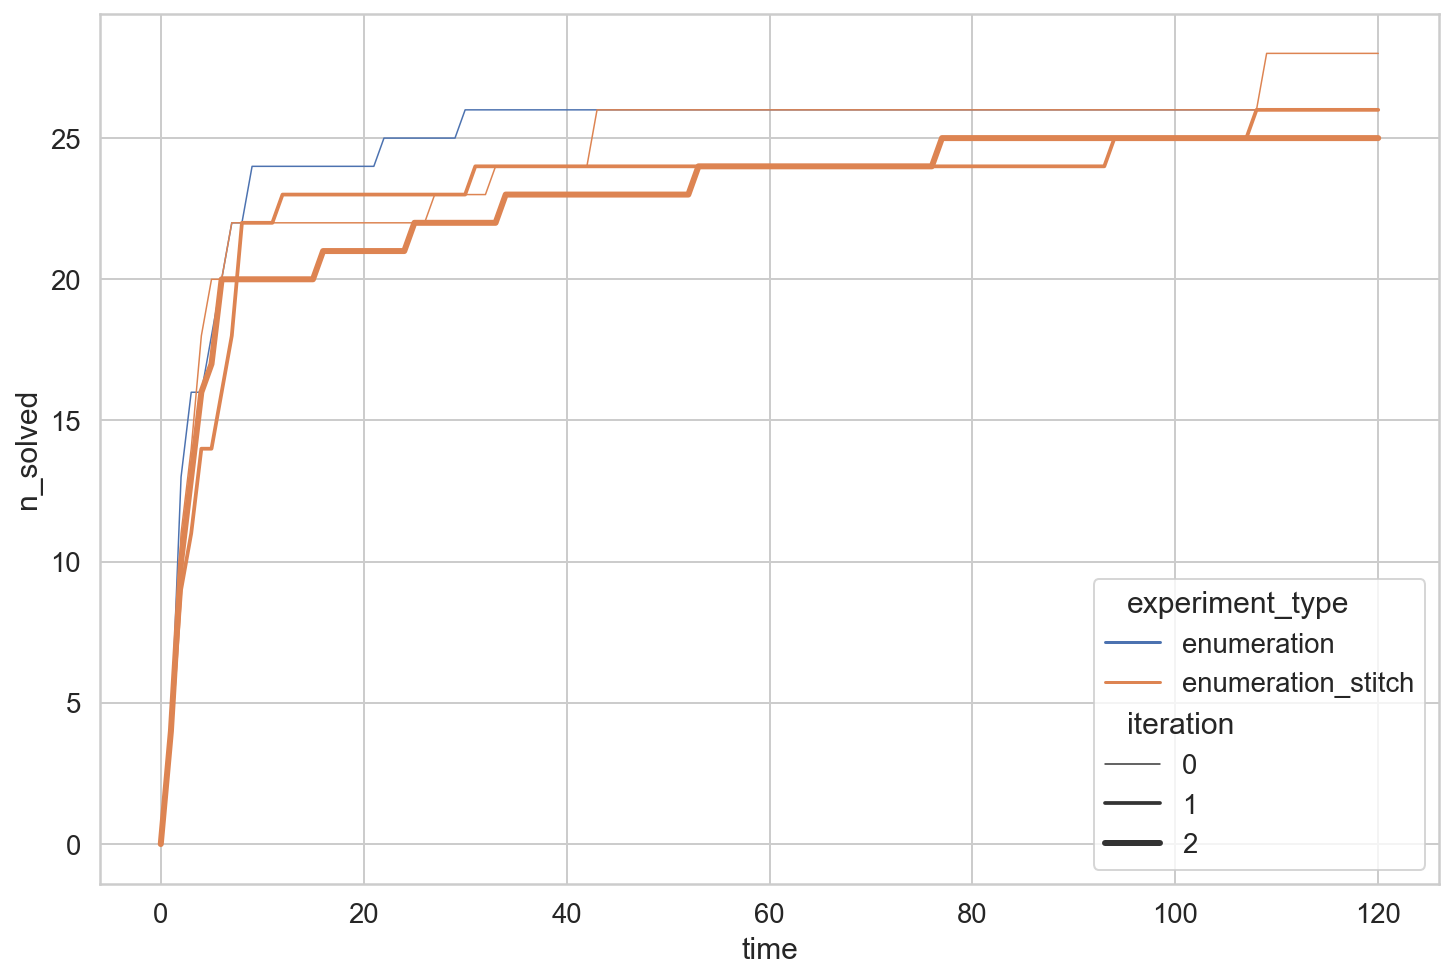

In [30]:
sns.lineplot(
    data=df_search_time[df_search_time.split == "test"],
    x="time",
    y="n_solved",
    hue="experiment_type",
    size="iteration"
)

<AxesSubplot:xlabel='time', ylabel='n_solved'>

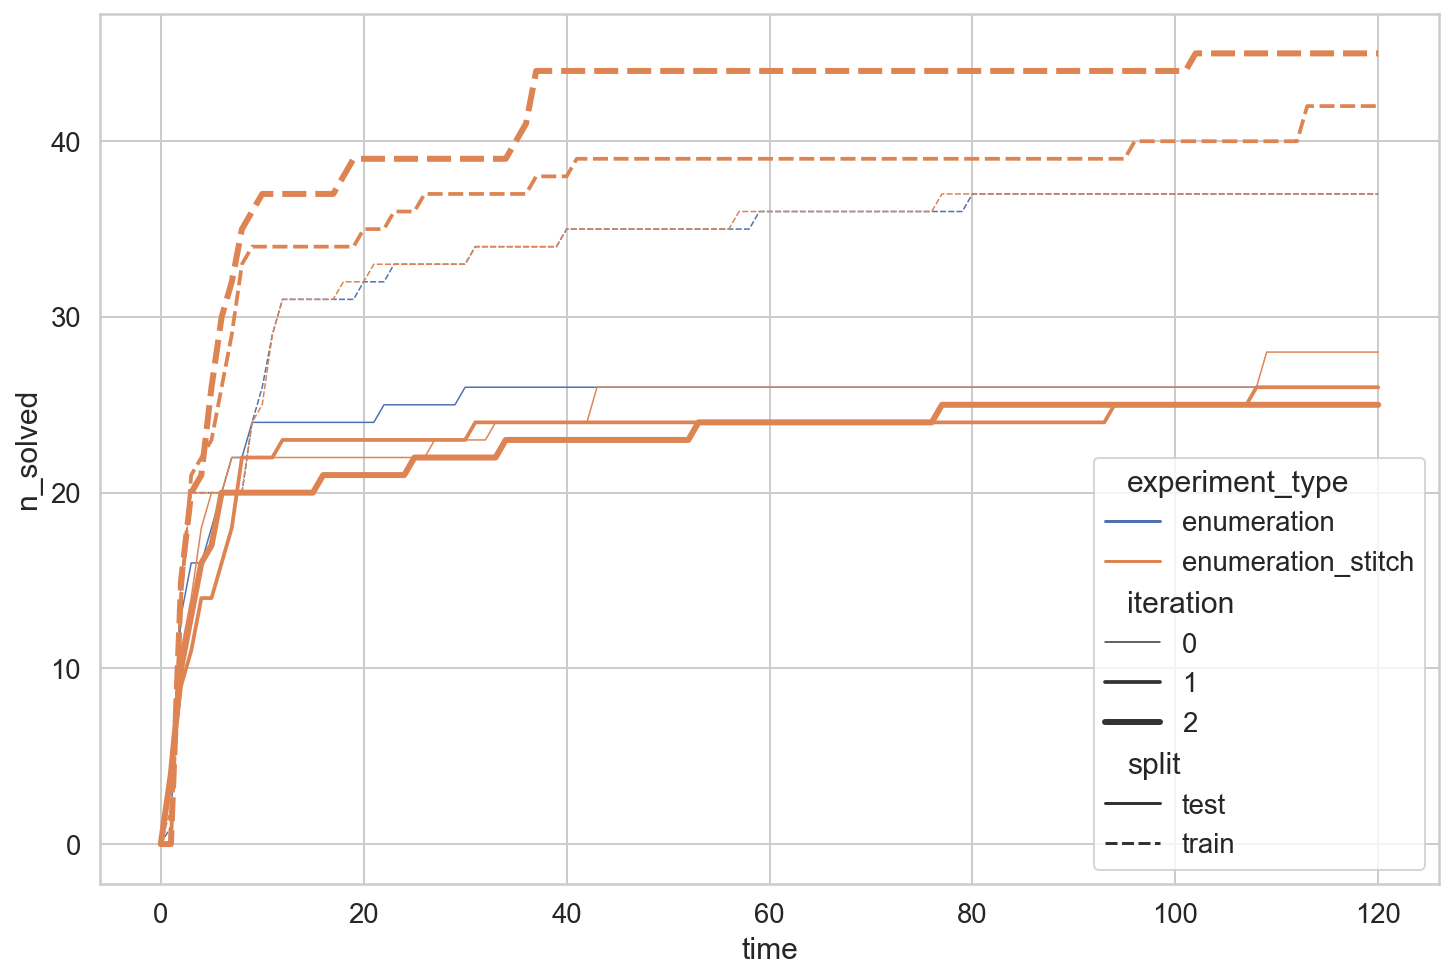

In [31]:
sns.lineplot(
    data=df_search_time,
    x="time",
    y="n_solved",
    hue="experiment_type",
    style="split",
    size="iteration",
)